In [1]:
import numpy as np

From website:

- state : ndarray (dim_state, 1), default = [0,0,0…0]
filter state estimate
- P : ndarray (dim_state, dim_state), default eye(dim_x)
covariance matrix
- R : ndarray (dim_measured_value, dim_z), default eye(dim_x)
measurement uncertainty/noise
- measurement_func, : ndarray (dim_measured_value, dim_x)
measurement function
- B : ndarray (dim_state, dim_u), default 0
control transition matrix


- `dim_x` is the size of the state vector
- `dim_z` is the size of the measurement vector
- `dim_u` is the size of the control input?
  - What is this?


Use as a function, from docs
```python
while True:
    measured_value, R = read_sensor()
    state, cov_mat = predict(state, cov_mat, F, Q)
    state, cov_mat = update(state, cov_mat, measured_value, measurement_noise, measurement_func,)
```

state,cov_mat = update(state, cov_mat, measured_value, measurement_noise, measurement_func,)

In [2]:
def simple_kalman(z,sigma,z_meas,sigma_meas):
    variance = sigma**2
    variance_meas= sigma_meas**2
    gain = variance/(variance+variance_meas)
    znew = z +gain*(z_meas-z)
    # get the new variance and convert it to a standard deviation
    sigmanew = ((1-gain)*variance)**0.5
    return znew,sigmanew



In [3]:
import rasterio

In [4]:
# load the results of the 
krige_results = rasterio.open('../data/resample_test/interp.tif')
gebco_interp = rasterio.open('../data/resample_test/bilinear.tif')

In [5]:
gebco_depth = gebco_interp.read(1)
kriged_depth = krige_results.read(1)
# convert variance to std dev
kriged_std = np.sqrt(krige_results.read(2))
gebco_uncertainty = np.full_like(gebco_depth,2)

In [6]:
updated_depth_grid,updated_uncertainty_grid = simple_kalman(gebco_depth,gebco_uncertainty,kriged_depth,kriged_std)

In [7]:
import matplotlib.pyplot as plt

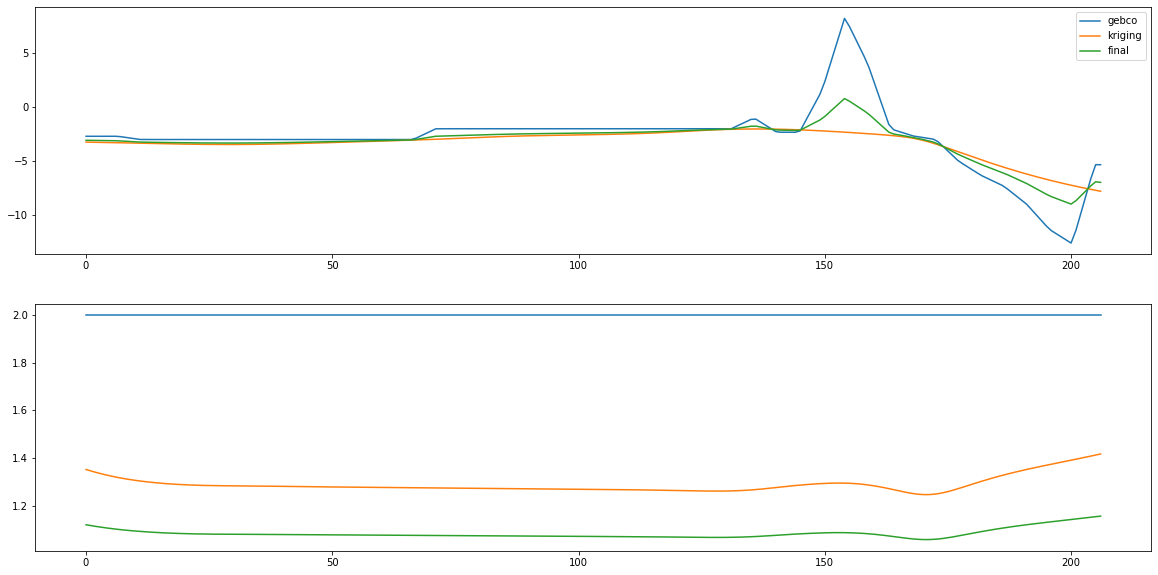

In [8]:
row = 100
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(20,10))
for grid in [gebco_depth,kriged_depth,updated_depth_grid,]:
    ax1.plot(grid[:,row])
for uncertaintygrid in [gebco_uncertainty,kriged_std,updated_uncertainty_grid]:
    ax2.plot(uncertaintygrid[:,row])
    
ax1.legend(['gebco','kriging','final'])


In [10]:
with rasterio.open('../data/resample_test/kalman_updated.tif',mode='w+',crs=gebco_interp.crs,width=gebco_interp.width,height=gebco_interp.height,count=1,dtype=gebco_interp.dtypes[0],transform=gebco_interp.transform) as outras:
    outras.write(updated_depth_grid,1)